In [1]:
from fastai.vision.all import *
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
valid_fnames = (path/'valid.txt').read_text().split('\n')


In [4]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [5]:
path_im = path/'images'
path_lbl = path/'labels'

In [6]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

<AxesSubplot:>

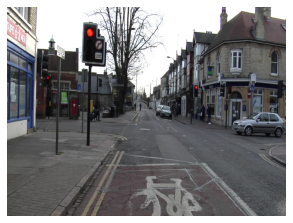

In [7]:
img_fn = fnames[50]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [8]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

<AxesSubplot:>

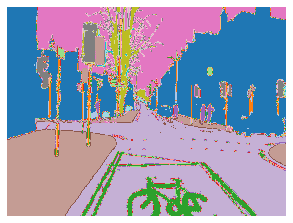

In [9]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [10]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [13]:
sz = msk.shape; sz

(720, 960)

In [14]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [15]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [16]:
dls = camvid.dataloaders(path/'images', bs=8)

/home/ec2-user/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/ec2-user/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /o

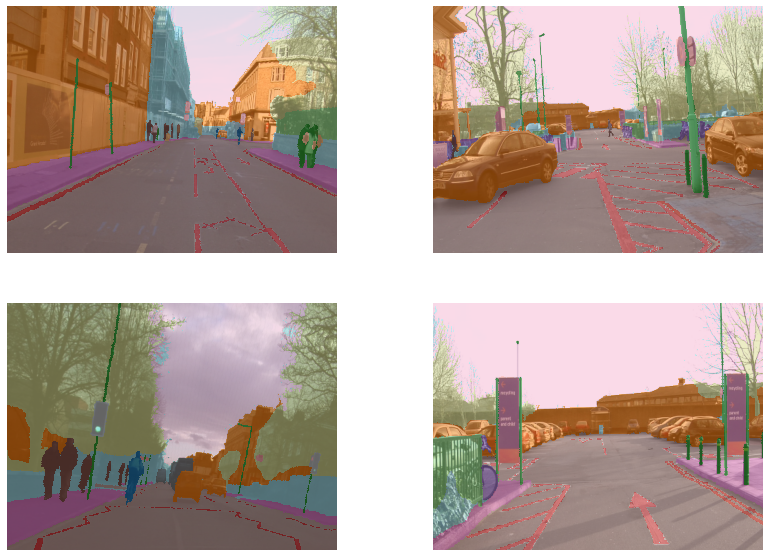

In [17]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [18]:
dls.vocab = codes

In [19]:
name2id = {v:k for k,v in enumerate(codes)}

In [20]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [21]:
void_code = name2id['Void']

In [22]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [23]:
opt = ranger

In [24]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

In [25]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 360 x 480)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 90 x 120   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [26]:
#learn.lr_find()

In [27]:
lr = 1e-3

In [28]:
learn.fit_flat_cos(5, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.170764,0.629923,0.834809,03:41
1,0.725069,0.484129,0.864967,03:27
2,0.569826,0.443151,0.877444,03:27
3,0.475843,0.342282,0.902190,03:27
4,0.397552,0.313022,0.909247,03:27


In [29]:
learn.save('stage-1')
learn.load('stage-1');

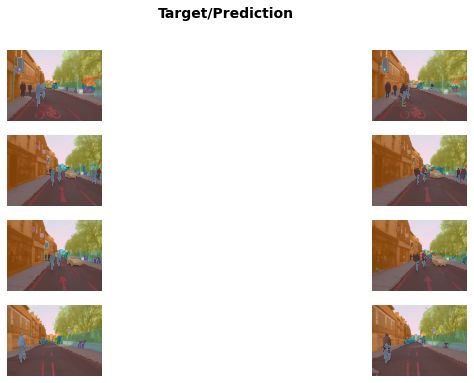

In [30]:
learn.show_results(max_n=4, figsize=(12,6))

In [31]:
lrs = slice(lr/400, lr/4)

In [32]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [33]:
learn.unfreeze()

In [34]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.351744,0.306349,0.911666,03:34
1,0.336850,0.285122,0.919129,03:35
2,0.318173,0.294710,0.910349,03:35
3,0.307229,0.267618,0.923611,03:35
4,0.292060,0.294790,0.913598,03:35
5,0.278426,0.262418,0.923172,03:35
6,0.264853,0.285504,0.912496,03:35
7,0.257663,0.266077,0.920639,03:35
8,0.246880,0.272880,0.919339,03:35
9,0.239490,0.259416,0.923499,03:37


In [35]:
learn.save('model_1')

Path('models/model_1.pth')

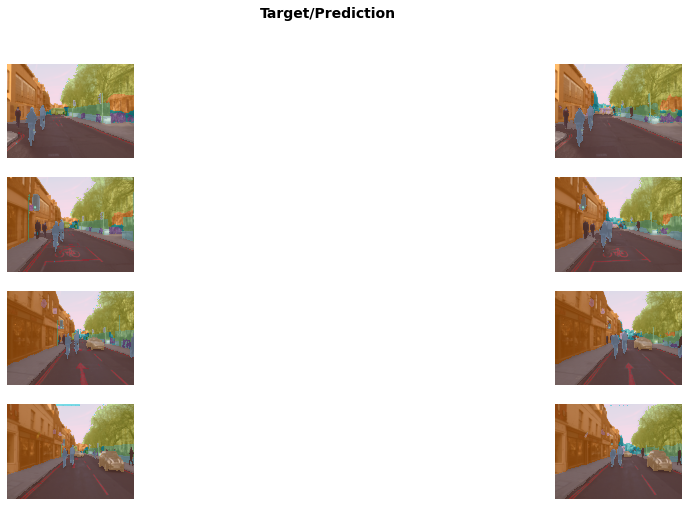

In [36]:
learn.show_results(max_n=4, figsize=(18,8))

In [37]:
dl = learn.dls.test_dl(fnames[:5])

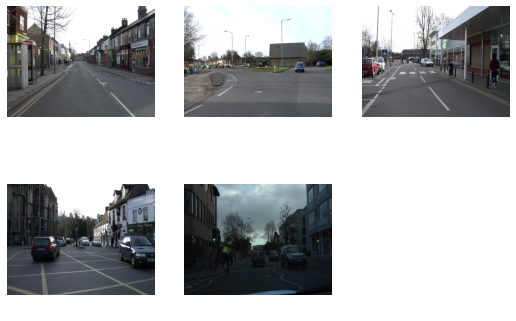

In [38]:
dl.show_batch()

In [39]:
preds = learn.get_preds(dl=dl)

In [40]:
preds[0].shape

torch.Size([5, 32, 360, 480])

In [41]:
len(codes)

32

In [42]:
pred_1 = preds[0][0]

In [43]:
pred_1.shape

torch.Size([32, 360, 480])

In [44]:
pred_arx = pred_1.argmax(dim=0)

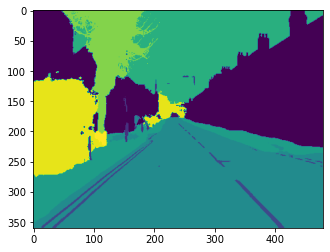

In [45]:
plt.imshow(pred_arx)

In [46]:
pred_arx = pred_arx.numpy()


In [47]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [48]:
im = Image.fromarray(rescaled)

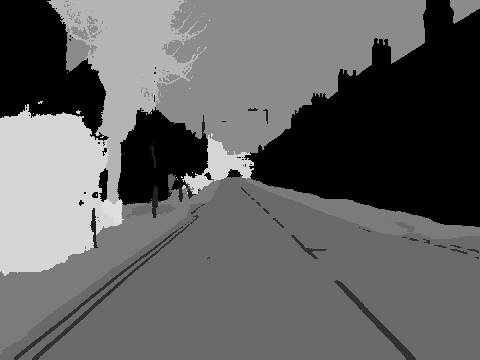

In [49]:
im


In [50]:
im.save('test.png')


In [51]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

In [52]:
torch.save(preds[0][0], 'Image_1.pt')

In [53]:
pred_1 = torch.load('Image_1.pt')

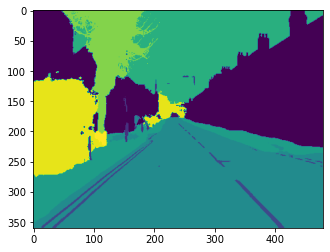

In [54]:
plt.imshow(pred_1.argmax(dim=0))